In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
from GeoDS import hypercube
from GeoDS.prospectivity import hyperparameterstuning
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS import reporting 
from GeoDS.prospectivity import featureimportance as fe
from GeoDS import eda
from GeoDS import datawrangle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from joblib import dump, load
import glob
from dask import dataframe as dd

import optuna
from optuna import pruners
from imblearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

#import tensorflow as tf
#import tensorflow_data_validation as tfdv
#from tensorflow_metadata.proto.v0 import schema_pb2

#print('TFDV Version: {}'.format(tfdv.__version__))
#print('Tensorflow Version: {}'.format(tf.__version__))

plt.rcParamsDefault["figure.figsize"] = [20., 20.]
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

from new_util import *


In [2]:
crs = 'epsg:26918'
AOI = 'Inputs/AOI/shape/AOI_geol.shp'
pixel_size = 5
xRes = pixel_size
yRes = pixel_size

# Random seed
random_state = 42

In [3]:
trial_name = 'ProgressBarTest'

reporting_folder = os.path.join(trial_name, 'reporting/')
output_folder = os.path.join(trial_name, 'outputs/')
predictions_folder = os.path.join(trial_name, 'predictions/')
CatBoost_predictions_folder = os.path.join(predictions_folder, 'CatBoost_predictions/')
RF_predictions_folder = os.path.join(predictions_folder, 'RF_predictions/')
LGBM_predictions_folder = os.path.join(predictions_folder, 'LGBM_predictions/')
SVM_predictions_folder = os.path.join(predictions_folder, 'SVM_predictions/')

if not os.path.exists(reporting_folder):
    os.makedirs(reporting_folder)
        
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder) 

if not os.path.exists(CatBoost_predictions_folder):
    os.makedirs(CatBoost_predictions_folder)

if not os.path.exists(RF_predictions_folder):
    os.makedirs(RF_predictions_folder)
    
if not os.path.exists(LGBM_predictions_folder):
    os.makedirs(LGBM_predictions_folder)

if not os.path.exists(SVM_predictions_folder):
    os.makedirs(SVM_predictions_folder) 

In [51]:
import glob
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import warnings
from pathlib import Path
import rioxarray
from osgeo import gdal, gdalconst
from GeoDS import utilities
import subprocess
import xarray
import json


def _reproject_tif_folder(input_folder, output_folder, crs, xRes, yRes):
    tifs = glob.glob(os.path.join(input_folder, '*.tif'))

    if not len(tifs) > 0:
        raise ValueError(
            "The input folder you provided do not contain any geotiffs. Please check your spelling.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for t in tifs:
        filename, ext, directory = utilities.Path_Info(t)
        newname = filename + '.tif'
        newpath = os.path.join(output_folder, newname)

        utilities.warp(input_geotiff=t, output_geotiff=newpath,
                       dstSRS=crs, xRes=xRes, yRes=yRes)


def _get_geotiff_information(input_tif):
    src = rasterio.open(input_tif)
    if(src.crs == None):
        # In case no CRS exists
        crs = 'INVALID CRS. CRS = None. PLEASE CHECK.'
    else:
        try:
            # We need a try statement in case the CRS is a weird output by oasis montaj. Could not repeat the exact issue I had with the output from Michael Cain but I think this will handle future issues.
            crs = src.crs['init']
        except:
            crs = 'INVALID CRS. CANNOT ACCES [\'init\'] property. PLEASE CHECK.'
            pass

    shape = src.shape
    nb_bands = src.count
    types = src.dtypes
    nodata_values_by_bands = src.nodatavals
    nodata_value = src.nodata
    # not using the src.transform
    try:
        gt = src.transform
        pixelSizeX = gt[0]
        pixelSizeY = -gt[4]
        resolution = (pixelSizeX, pixelSizeY)
    except:
        resolution = ('error cannot access transform attribute',
                      'error cannot access transform attribute')
        pass

    from shapely.geometry import box
    bounds = src.bounds
    geom = box(*bounds)
    src.close()

    return crs, shape, nb_bands, types, nodata_values_by_bands, nodata_value, resolution, geom


def sanity_check(input_directories, working_aoi, working_crs, output_directory='Sanity_Report/'):
    """
    Performs a validation on each on the input layers. Will output a csv to assess shape, crs, nb_bands, resolution, bounding box in working AOI, nodata value
    I suggest you do this and before each project, make sure that all the layers have the right and same CRS, the same no-data value, are single-bands, non corrupt and contained in the working AOI.
    Parameters
    ----------
    input_directory : list
        list where each element is a string of the path to the directory which contains all the input geotiff
    working_aoi : str
        path to a shapefile containing a sole polygon of the aoi. That polygon should have only one field called 'value' and set to 1
    working_crs : str
        the destination CRS, such as "epsg:26921" per example. Not implemented yet, will help to have a column that tells if CRS is good or not.
    Returns
    -------
        None
    Examples
    --------
        Perform a sanity check. Will ouput a report (excel format) in Sanity_Report/ folder .
        >>> datawrangle.sanity_check(input_directories='path_to_input/layers/folder/', working_aoi='path/to/aoi.shp', working_crs='epsg:31981')
    """
    files_names = []
    for dir in input_directories:
        names = glob.glob(os.path.join(dir, "*.tif"))
        files_names.extend(names)

    if (len(files_names) == 0):
        # This means that the input_directory is empty or no data is contained.
        print("Input folder is either empty or you gave the wrong path. Please double check and come back.")
        return None

    df = pd.DataFrame(files_names, columns=['file_name'])
    df['crs'], df['shape'], df['nb_bands'], df['types'], df['nodata_values_by_bands'], df['nodata_value'], df[
        'resolution_x_y'], df['bounding_box'] = zip(
        *df.apply(lambda x: _get_geotiff_information(x['file_name']), axis=1))

    aoi_gdf = gpd.read_file(working_aoi)
    aoi_poly = aoi_gdf['geometry'].loc[0]
    df['is_in_aoi'] = df.apply(
        lambda x: x['bounding_box'].intersects(aoi_poly), axis=1)

    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    # Save bouding boxes
    d = {'file_name': df['file_name'], 'geometry': df['bounding_box']}
    gdf = gpd.GeoDataFrame(d, crs=working_crs)
    gdf.to_file(os.path.join(output_directory, 'Layers_Bouding_boxes.shp'))

    now = utilities.actual_time_for_file_name()
    final_name = os.path.join(
        output_directory, 'Sanity_Report_' + now + '.xlsx')
    df.to_excel(final_name)
    print("Sanity check completed. Please see the report file %s " % final_name)


def make_abstract_grid_csv(aoi_tif, output_directory):
    """
    Outputs a .csv containing x,y coordinates of all the cells of the AOI rasters (an abstract grid).
    Parameters
    ----------
    aoi_tif : str
        path to the aoi geotiff
    output_directory : str
        path to where the abstract grid will be saved
    Returns
    -------
    grid : str
        path to the abstract grid csv
    """

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    grid = os.path.join(output_directory, 'abstract_grid.csv')
    if os.path.exists(grid):
        os.remove(grid)

    utilities.geotiff_to_csv(aoi_tif, grid)

    return grid


def build_stack_cdf(input_numerical_folder, input_categorical_folder, output_folder, aoi_shapefile, working_crs, x_res, y_res, output_format='csv', ensure_tif_reprojection=True):
    """
    DataWrangle main function. Creates a hypercube csv using NetCDF as internal mechanism for enhanced performances.
    Outputs a .csv of the HyperCube.
    Parameters
    ----------
    input_numerical_folder: str
        directory containing numerical layers
    input_categorical_folder: str
        directory containing categorical layers
    output_folder : str
        directory for the hypercube output
    aoi_shapefile: str
        path to a shapefile that has a polygon representing the area of interest
    working_crs: str
        working CRS, per example 'epsg:26921'
    x_res: int
        x_resolution
    y_res: int
        y_resolution
    output_format : str, default='csv'
        Output format for the cube. Available options are 'csv' or 'netCDF'
    ensure_tif_reprojection : bool, default = True
        Will automatically perform gdal.warp on each of the individual input files to fix unexpected behaviors when it comes to build a VRT. Performance will be decreased but we suggest to keep it this way.
    Returns
    -------
    None
    Examples
    -------
        Build a HyperCube (csv).
        >>> datawrangle.build_stack_cdf(input_numerical_folder='input_layers_numerical/', input_categorical_folder='input_layers_categorical/', output_folder='output/', aoi_shapefile='AOI/AOI_2021.shp', working_crs='epsg:31981', x_res=25, y_res=25)
    """
    warnings.warn(
        "This function is deprecated, Please use cube_vrt if this function throws NetCDF errors", ResourceWarning)
    print("Processing...")
    # QAQC the output format
    formats = ['csv', 'netcdf']
    output_format = output_format.lower()
    if output_format not in formats:
        raise ValueError(
            "Output format you specified is not supported. Supported types : 'csv', 'netcdf'. Processing aborted.")

    # QAQC THE AOI
    if(os.path.isfile(aoi_shapefile)):
        aoi = gpd.read_file(aoi_shapefile)
        if(len(aoi.geom_type) == 0):
            print("Your AOI shapefile is empty. Processing aborted.")
            return
        else:
            for t in aoi.geom_type:
                if t != 'Polygon':
                    print(
                        'There is a geometry that is not a polygon in your AOI. Go in QGIS and fix this. Processing aborted.')
                    return

            for v in aoi['geometry'].is_valid:
                if v == False:
                    print(
                        'There is an invalid geometry in your polygon (self-crossing itself, per example). Go in QGIS and fix this. Processing aborted.')
                    return
    else:
        raise ValueError(
            "The path of the AOI shapefile you provided is wrong. Please double check. Processing aborted.")

    # QAQC if to see if folder provided do exists and are not empty
    numeric_files = glob.glob(os.path.join(input_numerical_folder, "*.tif"))
    if (len(numeric_files) == 0):
        raise ValueError(
            "The input NUMERICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    cat_files = glob.glob(os.path.join(input_categorical_folder, "*.tif"))
    if (len(cat_files) == 0):
        raise ValueError(
            "The input CATEGORICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    if(ensure_tif_reprojection == True):
        print("Reprojecting your numerical files")
        output_folder_numerical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_numerical/')
        _reproject_tif_folder(
            input_numerical_folder, output_folder_numerical_warped, working_crs, x_res, y_res)
        numeric_files = glob.glob(os.path.join(
            output_folder_numerical_warped, '*.tif'))

        print("Reprojecting your categorical files")
        output_folder_categorical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_categorical/')
        _reproject_tif_folder(
            input_categorical_folder, output_folder_categorical_warped, working_crs, x_res, y_res)
        cat_files = glob.glob(os.path.join(
            output_folder_categorical_warped, '*.tif'))

    print("Cubing numerical files...")
    _to_netcdf(numeric_files, os.path.join('temp_numeric_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='cubic', output_type=gdal.GDT_Unknown)
    _rename_bands(numeric_files, os.path.join('temp_numeric_cube.nc'))
    print("Partial numerical cube on {} layers done".format(len(numeric_files)))

    _to_netcdf(cat_files, os.path.join('temp_cat_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='near', output_type=gdal.GDT_Int16)
    _rename_bands(cat_files, os.path.join('temp_cat_cube.nc'))
    print("Partial categorical cube on {} layers done".format(len(cat_files)))
    print("merging categorical and numerical features into one...")

    _merge_cubes(os.path.join('renamed_temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_cat_cube.nc'), output_folder, output_format)
    print("Cube creation completed. Cleaning unnecessary files from the disk")

    temp_ncs = [os.path.join('temp_cat_cube.nc'), os.path.join('temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_numeric_cube.nc'), os.path.join('renamed_temp_cat_cube.nc')]
    for f in temp_ncs:
        try:
            os.remove(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

    return None


def _to_netcdf(input_geotiffs, output_nc, working_aoi_polygon, working_crs, x_res, y_res, resampling_method,
               output_type, nodata=-99999):
    """
    Parameters
    ----------
    output_type: GDAL outputtype used for experientation
    input_geotiffs: isolate dinput directory containing only numerical or categorical dataset
    output_nc: Output directory
    working_aoi_polygon: working area of interest
    working_crs: working CRS
    x_res: X resolution
    y_res: y resolution
    resampling_method : resampling method 'near' for categorical dataset and 'cubic' for numerical
    nodata: -99999 represents all the null values in the dataset
    Returns
    -------
    individual processed files  with .nc extension in your selected directory
    """

    buildvrt_options = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                            VRTNodata=nodata, resampleAlg=resampling_method, separate=True)
    one_vrt = gdal.BuildVRT(
        destName="", srcDSOrSrcDSTab=input_geotiffs, options=buildvrt_options)
    # We Warp it for alignement, resampling, correct CRS and cropping.
    warp_options = gdal.WarpOptions(format='NetCDF', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg=resampling_method,
                                    srcNodata=nodata,
                                    dstNodata=nodata,
                                    outputType=output_type)
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=one_vrt, destNameOrDestDS=output_nc, options=warp_options)

    if(warp_output_vrt == None):
        print("output of gdal.warp() is None. Possible causes are corrupted input files or inputs files not contained in AOI. Processing aborded.")

        return
    warp_output_vrt = None
    output_nc = None
    return


def _rename_bands(input_files, nc_file):
    # PH's comment : Jan 28 2022. This function could be removed easily and performances would increase drastically also. It is just a matter of finding how to rename "dimensions" in rioxarray which I did not knew the week I built datawrangle.

    renames = {}
    for index, f in enumerate(input_files):
        filename, directory, extension = utilities.Path_Info(f)
        band_name = 'Band' + str(index + 1)
        renames[band_name] = filename
    # rename the output_nc step
    ds = xarray.open_dataset(nc_file)
    x = ds.rename(renames)

    x.to_netcdf(os.path.join('renamed_' + nc_file))
    ds.close()

    return None


def _merge_cubes(a, b, output_folder, output_format):
    print("If merging looks to take forever, restart your kernel and delete the temp files.")
    cube = xarray.open_mfdataset([a, b], parallel=True)
    cube = cube.drop_vars(['transverse_mercator'])
    print('Merging completed')
    now = utilities.actual_time_for_file_name()

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if(output_format == 'csv'):
        print("Writing ouput CSV, this is the longest step, it may take a while...")
        out_name = os.path.join(output_folder, 'Hypercube_' + now + '.csv')
        df = cube.to_dataframe().reset_index()
        #     df.drop(columns=['transverse_mercator'], inplace=True)
        df.set_index(['x', 'y'], inplace=True)
        df = df.dropna(axis=0, how='all')
        df.to_csv(out_name, index=True, chunksize=10000)
    elif(output_format == 'netcdf'):
        print("Writing output NetCDF file (nc)...")
        out_name = os.path.join(
            output_folder, 'Netcdf_Hypercube_' + now + '.nc')
        cube.to_netcdf(out_name)

    cube.close()
    print("Cube built with success.")
    return None


def reconstruct_geotiffs_from_cube(input_cube, output_folder, crs, x_field='x', y_field='y', xRes=25, yRes=25):
    """
    QAQC function to create rasters for each column of the HyperCube. The goal is that both the geologist and data scientist could have a look at the resampled, realigned geotiff and confirm the cube is well in shaped and ML work can start.
    Parameters
    ----------
    input_cube : str
        path to the input csv of the HyperCube
    output_folder : str
        directory where to save new output folders
    crs : str
        crs of the project, example 'epsg:26921'
    x_field : str, default='x'
        name of the x coordinate column
    y_field : str, default='y'
        name of the y coordinate column
    xRes : int, default=25
        x resolution
    yRes : int, default=25
        y resolution
    Returns
    -------
    None
    Examples
    --------
        Rasterize each column of the cube back to its original geotiff format.
        >>> datawrangle.reconstruct_geotiffs_from_cube(input_cube='Netcdf_Hypercube_10-22-2021_1621.csv', output_folder='QAQC_outputs/', crs='epsg:26921', x_field='x', y_field='y', xRes=25, yRes=25)
    """
    # open the dataframe, read only the columns
    df = pd.read_csv(input_cube, nrows=2)
    cols = df.columns

    # get all columns
    for col in cols:
        if (col != x_field and col != y_field):
            print("Rebuilding column " + col)
            new_name = 'Rebuilt_from_cube_' + col + '.tif'
            output = output_folder + new_name
            # utilities.csv_to_raster(input_cube, output,crs, x_field, y_field, col, xRes, yRes)
            utilities.csv_to_raster(
                input_cube, output, crs, x_field, y_field, col, xRes, yRes)

    print('Cube reconstructed. See in ' + output_folder)
    return None

def get_bands(file_list):
    bands = []
    for e in file_list:
        filename, ext, directory = utilities.Path_Info(e)
        bands.append(filename)
    return bands

def set_band_descriptions(filepath, bands):
    """
    filepath: path/virtual path/uri to raster
    bands:    ((band, description), (band, description),...)
    """
    bands_numbers = np.arange(1, len(bands) + 1, 1).tolist()
    bands = zip(bands_numbers, bands)
    ds = gdal.Open(filepath, gdal.GA_Update)
    for band, desc in bands:
        rb = ds.GetRasterBand(band)
        rb.SetDescription(desc)
    del ds

def read_vrt_to_df(vrt):
    """ Read a VRT stack into a pandas.DataFrame with x,y coordinates columns
    for compatibility with datawrangle.
    Parameters
    ----------
    vrt : str
        Path to VRT file to be read.
    """
    xar = rioxarray.open_rasterio(vrt)

    if type(xar.attrs["long_name"]) == str:
        feats = xar.attrs['long_name']
        feats = list(xar.attrs['long_name'])
        feats = ''.join(feats)
        feats = [feats]
    if type(xar.attrs["long_name"]) == tuple:
        feats = list(xar.attrs['long_name'])

    del xar

    # Read data and flatten arrays
    with rioxarray.open_rasterio(vrt, masked=True) as ds:
        x_coords = ds.coords['x'].values
        y_coords = ds.coords['y'].values
        data_array = ds.data
        l, m, n = data_array.shape
        data_flat = np.empty((m * n, l))
        for i in range(l):
            flat = data_array[i].flatten()
            data_flat[:, i] = flat
    # Extract coordinates - this imbricated loop oculd be enhanced
    i = 0
    coords = np.empty((m * n, 2))
    for y in y_coords:
        for x in x_coords:
            coords[i] = [x, y]
            i += 1
    # Concatenate and write df
    final_array = np.concatenate((coords, data_flat), axis=1)
    headers = ['x', 'y'] + feats
    del data_flat
    df = pd.DataFrame(data=final_array, columns=headers)
    return df

def cube_vrt(input_folders_list, 
             output_folder, 
             x_res, 
             y_res, 
             working_crs, 
             working_aoi_polygon, 
             save_vrt=True, 
             save_csv=True,
             save_columns = True):
    """
    Parameters
    ----------
    input_folders_list : list
        list of list with all folders containing input data
    output_folder : str
        Given output folder name will be created containing the cube data.
    x_res: int
        x resolution
    y_res: int
        y resolution
    working_crs : str
        working CRS, per example 'epsg:26921'
    working_aoi_polygon: str
        path to a shapefile that has a polygon representing the area of interest
    save_vrt : Boolean
        default : True
        Saves vrt format of the cube in output folder
    save_csv : Boolean
        default : True
        Saves csv format of the cube in output folder
    save_columns : Boolean
        default : True
        Saves JSON format of the columns names used while buildign the cube
    Returns
    -------
    cube : pandas.DataFrame
        resultant cube
    Examples
    --------
    # cube
    crs = 'epsg:32733'
    x_res = 10
    y_res = 10
    output_folder = 'project_outputs/'
    pred_aoi = 'aoi/Prediction AOI.shp'
    geofez_layers = 'prediction_features/geofez/'
    haralick_layers = 'prediction_features/unidirectional_w_5_d_1/'
    stat_layers = 'prediction_features/stat_features_window_kernel_5_5/'
    lbp_layers = 'prediction_features/lbp/'
    label_layers = 'prediction_features/labels/'
    input_directories = [geofez_layers,haralick_layers,stat_layers,lbp_layers,label_layers]
    datawrangle.cube_vrt(input_directories, output_folder, x_res, y_res, crs, pred_aoi, 
    save_vrt=True, save_csv=True)
    """
        
    all_files = []
    bands = [] 
    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)
    input_name_list = []
    
    for f in input_folders_list:
        
        temp = glob.glob(os.path.join(f, "*.tif"))
        
        for j in temp:
            input_name = os.path.basename(j).split('.')[0]
            input_name_list.append(input_name)
        
        if(len(temp) == 0):
            raise ValueError(
                "The input folder path %f you provided do not contain any geotiffs. Processing aborted." % f)
        all_files.extend(temp)
        bands.extend(get_bands(temp))
        features = {'features' : input_name_list}
        
    columns.update(features)
        
    parent = Path(input_folders_list[0]).parent
    now = utilities.actual_time_for_file_name()

    nodata = -9999
    #print("There are %s numerical layers and %s categorical layers "% (str(len(numeric_files)), str(len(cat_files))))

    buildvrt_options1 = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                             VRTNodata=nodata, resampleAlg='near', separate=True)

    combined = os.path.join(parent, "combined_cat_numeric_vrt_"+now+".vrt")
    numerical_vrt = gdal.BuildVRT(
        destName=combined, srcDSOrSrcDSTab=all_files, options=buildvrt_options1)
    numerical_vrt = None

    # change band1 band2 band3 by the real variable name
    #bands = get_bands(numeric_files) + get_bands(cat_files)
    set_band_descriptions(combined, bands)

    warp_options = gdal.WarpOptions(format='vrt', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg='near',
                                    cropToCutline=True,
                                    outputType=gdal.GDT_Float32,
                                    dstNodata=nodata, copyMetadata=True, multithread=True
                                    )

    output_vrt = os.path.join(parent, 'hypercube_' + now + '.vrt')
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=combined, destNameOrDestDS=output_vrt, options=warp_options)
    warp_output_vrt = None

    print('Converting vrt to dataframe... may take a while')
        
    cube = read_vrt_to_df(output_vrt)
    if save_columns:
        print('Now writing columns in json')
        now = utilities.actual_time_for_file_name()
        output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
        with open(os.path.join(output_json_name), 'w') as fp:
            json.dump(columns, fp)
       
    if(save_csv == True):
        print('Now writing csv ....... may take a while')
        output_cube_name = os.path.join(output_folder, os.path.basename(output_vrt).split('.')[0] + '.csv')
        cube.to_csv(output_cube_name, index=False)
    else:
        print("Not saving the cube to csv.")
              
    if(save_vrt == False):
        os.remove(combined)
        os.remove(output_vrt)
    else:
        print("Your hypercube was also saved under .vrt format (two files necessary) in the input data folder : %s " % parent)

    print("Cube Creation Completed. ")
    return cube, columns

def add_features(
    current_dataframe,
    input_directories,
    output_folder,
    x_res,
    y_res,
    crs,
    aoi_shapefile,
    save_vrt=False,
    save_csv=True
):
    """
    Add extra features to existing data cube
    Example:
    trial_name = 'RawBaseline_Amaruq_May29'
    input_directories = ['targets/']
    output_folder = os.path.join(trial_name, 'outputs/')
    x_res = 25
    y_res = 25
    crs = 'epsg:26914'
    aoi_shapefile_amaruq = 'AOI_Amaruq/Amaruq_AOI.shp'
    df_combined, columns = datawrangle.add_features(
            df_current,    
            input_directories,
            output_folder, 
            x_res, 
            y_res,
            crs, 
            aoi_shapefile_amaruq, 
            save_vrt=True,
            save_csv=False
            )
    """
    #TODO: Check/make output folder if it does not exist
    df_addition, _ = cube_vrt(
        input_directories,
        output_folder, 
        x_res,
        y_res,
        crs, 
        aoi_shapefile,
        save_vrt=save_vrt, 
        save_csv=save_csv
        )

    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)

    current_dataframe = pd.merge(current_dataframe, df_addition, on=(columns['coordinates']))

    feature_list = current_dataframe.columns[(current_dataframe.columns != 'x') & (current_dataframe.columns != 'y')].to_list()
    features = {'features' : feature_list}
    columns.update(features)
    
    print('Now writing columns in json')
    now = utilities.actual_time_for_file_name()
    output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
    with open(os.path.join(output_json_name), 'w') as fp:
        json.dump(columns, fp)  
        
    if(save_csv == True):
        now = utilities.actual_time_for_file_name()
        output_cube = os.path.join(output_folder, 'hypercube_' + now + '.csv')
        print('Now writing csv ....... may take a while')
        current_dataframe.to_csv(output_cube, index=False)
        print('Done!')
    else:
        print("Not saving the cube to csv.")

    return current_dataframe, columns

In [56]:
input_directories = ['Inputs/Features/Raster/test',
                     'Inputs/Targets/Raster/Au'
                    ]

df_Input, columns = cube_vrt(input_directories, 
                     output_folder, 
                     xRes, 
                     yRes, 
                     crs, 
                     AOI, 
                     save_vrt=False, 
                     save_csv=False)

Converting vrt to dataframe... may take a while
Now writing columns in json
Not saving the cube to csv.
Cube Creation Completed. 


In [57]:
df_Input.head()

,x,y,Critical_1xd,Critical_1yd,CRE_all_Au_ne_and_pos_raster
0,384727.5,5760787.5,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN


In [58]:
df_Input.columns.tolist()

['x', 'y', 'Critical_1xd', 'Critical_1yd', 'CRE_all_Au_ne_and_pos_raster']

In [59]:
# Numerical Layers
all_numerical = [
'Critical_1xd', 'Critical_1yd'
                 ]

keep_numerical = [
'Critical_1xd', 'Critical_1yd'
                ]
    
drop_numerical = [x for x in all_numerical if x not in keep_numerical]
 
# Categorical Layers
all_cats = [    
           ]

keep_cats = [
            ]
drop_cats = [x for x in all_cats if x not in keep_cats]

# Targets       
all_targets = [
              'CRE_all_Au_ne_and_pos_raster'
              ]
       
#targets_to_keep = ['DDH_Meadowbank_targets_b200','DDH_Meadowbank_targets_b200_target_id']
targets_to_keep = ['CRE_all_Au_ne_and_pos_raster']
targets_to_drop = [x for x in all_targets if x not in targets_to_keep]
target = targets_to_keep[0]
#target_group = targets_to_keep[1]
#targets = [target, target_group]
targets = [target]

coords = ['x', 'y']

columns = {
    'numerical' : keep_numerical,
    'categories': keep_cats,
    'targets': targets,
    'coordinates' : coords
}

In [60]:
cube = hypercube.HyperCube(input_data=df_Input, x_field='x', y_field='y', crs=crs)
cube.df.head()

,x,y,Critical_1xd,Critical_1yd,CRE_all_Au_ne_and_pos_raster
0,384727.5,5760787.5,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN


In [61]:
columns_to_drop = drop_numerical + drop_cats + targets_to_drop
columns_to_drop

[]

In [62]:
cube.df = cube.df.drop(columns=columns_to_drop)
cube.df.head()

,x,y,Critical_1xd,Critical_1yd,CRE_all_Au_ne_and_pos_raster
0,384727.5,5760787.5,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN


In [63]:
cube.df.columns

Index(['x', 'y', 'Critical_1xd', 'Critical_1yd',
       'CRE_all_Au_ne_and_pos_raster'],
      dtype='object')

In [64]:
cube.columns_dict = columns
cube.columns_dict

{'numerical': ['Critical_1xd', 'Critical_1yd'],
 'categories': [],
 'targets': ['CRE_all_Au_ne_and_pos_raster'],
 'coordinates': ['x', 'y']}

In [65]:
for i in cube.columns_dict['categories']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

for i in cube.columns_dict['targets']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

cube.df.dtypes

x                                float64
y                                float64
Critical_1xd                     float64
Critical_1yd                     float64
CRE_all_Au_ne_and_pos_raster    category
dtype: object

In [66]:
cube.summary()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358840498 entries, 0 to 358840497
Data columns (total 5 columns):
 #   Column                        Non-Null Count      Dtype   
---  ------                        --------------      -----   
 0   x                             358840498 non-null  float64 
 1   y                             358840498 non-null  float64 
 2   Critical_1xd                  21742025 non-null   float64 
 3   Critical_1yd                  21742025 non-null   float64 
 4   CRE_all_Au_ne_and_pos_raster  7228 non-null       category
dtypes: category(1), float64(4)
memory usage: 11.0 GB


In [67]:
# Percentage of null values
cube.show_nan_percentage()

Critical_1xd's null rate :93.94103%
Critical_1yd's null rate :93.94103%
CRE_all_Au_ne_and_pos_raster's null rate :99.99799%


In [68]:
subsets = ['numerical', 'categories']
for subset in subsets: cube.dropna(subset=subset)

In [69]:
# Percentage of null values
cube.show_nan_percentage()

CRE_all_Au_ne_and_pos_raster's null rate :99.97721%


In [70]:
cube.to_object(columns['categories'])
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21742025 entries, 40804394 to 306634301
Data columns (total 5 columns):
 #   Column                        Non-Null Count     Dtype   
---  ------                        --------------     -----   
 0   x                             21742025 non-null  float64 
 1   y                             21742025 non-null  float64 
 2   Critical_1xd                  21742025 non-null  float64 
 3   Critical_1yd                  21742025 non-null  float64 
 4   CRE_all_Au_ne_and_pos_raster  4956 non-null      category
dtypes: category(1), float64(4)
memory usage: 850.1 MB


In [71]:
X, y = cube.getRowsWithLabelOnly(subsets=['numerical', 'categories'], target=target)
#groups = cube.df[target_group].dropna()
#groups = cube.df[cube.df[target].notnull()][target_group]
#groups

In [72]:
all_X = cube.subset(['numerical', 'categories'])
all_X.shape

(21742025, 2)

In [73]:
X.shape

(4956, 2)

In [74]:
y.shape

(4956,)

In [75]:
np.unique(y.values, return_counts = True)

(array([0, 1], dtype=int32), array([4856,  100]))

In [76]:
# StratifiedGroupKFold
#group_kfold = StratifiedGroupKFold(n_splits=3)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

# GroupKFold
#group_kfold = GroupKFold(n_splits=5)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]    
     
# Random Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = random_state)


In [77]:
n_trials = 2
numeric_cols = columns['numerical']
#cat_indexes = cube.GetCatFeaturesIndexes(X_train)
cat_indexes = None
models = ['CatBoost','LGBM','SVM','RandomForest']
#models = ['XGBoost']
#cross_validation = StratifiedGroupKFold(n_splits=5)
#cross_validation = GroupKFold(n_splits=5)
cross_validation = KFold(n_splits=5)

hyperparameterstuning.Optimizer(n_trials, models, output_folder, numeric_cols, cat_indexes, X_train, y_train,
      cv = cross_validation, groups = None, scoring='f1_macro', random_state=random_state)

[I 2022-08-03 20:48:44,455] A new study created in memory with name: CatBoost_study


{'random_state': 42, 'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-08-03 20:48:51,620] Trial 0 finished with value: 0.6567809135763039 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.6567809135763039.


{'random_state': 42, 'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2022-08-03 20:48:55,612] Trial 1 finished with value: 0.6272512204857692 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.6567809135763039.
[I 2022-08-03 20:48:57,131] A new study created in memory with name: LGBM_study


Trained models saved in ProgressBarTest/outputs/models/ 
{'boosting_type': 'dart', 'num_leaves': 184, 'min_data': 73, 'max_depth': 34, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'learning_rate': 0.0006440507553993703, 'random_state': 42, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}


[I 2022-08-03 20:48:58,642] Trial 0 finished with value: 0.580464041273698 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 184, 'clf__min_data': 73, 'clf__max_depth': 34, 'clf__reg_alpha': 0.05808361216819946, 'clf__reg_lambda': 0.8661761457749352, 'clf__learning_rate': 0.0006440507553993703, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}. Best is trial 0 with value: 0.580464041273698.


{'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data': 77, 'max_depth': 63, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'learning_rate': 2.1371407316372935e-06, 'random_state': 42}


[I 2022-08-03 20:49:00,147] Trial 1 finished with value: 0.019737892523862873 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 62, 'clf__min_data': 77, 'clf__max_depth': 63, 'clf__reg_alpha': 0.5247564316322378, 'clf__reg_lambda': 0.43194501864211576, 'clf__learning_rate': 2.1371407316372935e-06}. Best is trial 0 with value: 0.580464041273698.


[LightGBM] [Warning] min_data_in_leaf is set with min_data=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73


[I 2022-08-03 20:50:50,617] A new study created in memory with name: SVM_study


Trained models saved in ProgressBarTest/outputs/models/ 
{'random_state': 42, 'probability': True, 'C': 0.17565327456519703, 'gamma': 517.0952091522892, 'kernel': 'rbf'}


[I 2022-08-03 20:50:59,542] Trial 0 finished with value: 0.6771565757119657 and parameters: {'C': 0.17565327456519703, 'gamma': 517.0952091522892, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6771565757119657.


{'random_state': 42, 'probability': True, 'C': 0.002184732321248571, 'gamma': 160.1769690624375, 'kernel': 'sigmoid'}


[I 2022-08-03 20:51:10,829] Trial 1 finished with value: 0.132800818204888 and parameters: {'C': 0.002184732321248571, 'gamma': 160.1769690624375, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.6771565757119657.
[I 2022-08-03 20:51:22,474] A new study created in memory with name: RandomForest_study


Trained models saved in ProgressBarTest/outputs/models/ 
{'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-08-03 20:51:29,206] Trial 0 finished with value: 0.6960150188918396 and parameters: {'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.6960150188918396.


{'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-08-03 20:51:38,694] Trial 1 finished with value: 0.6980709689674419 and parameters: {'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.6980709689674419.


Trained models saved in ProgressBarTest/outputs/models/ 


SVM_bestpipeline_fitted_model
CatBoost_bestpipeline_fitted_model


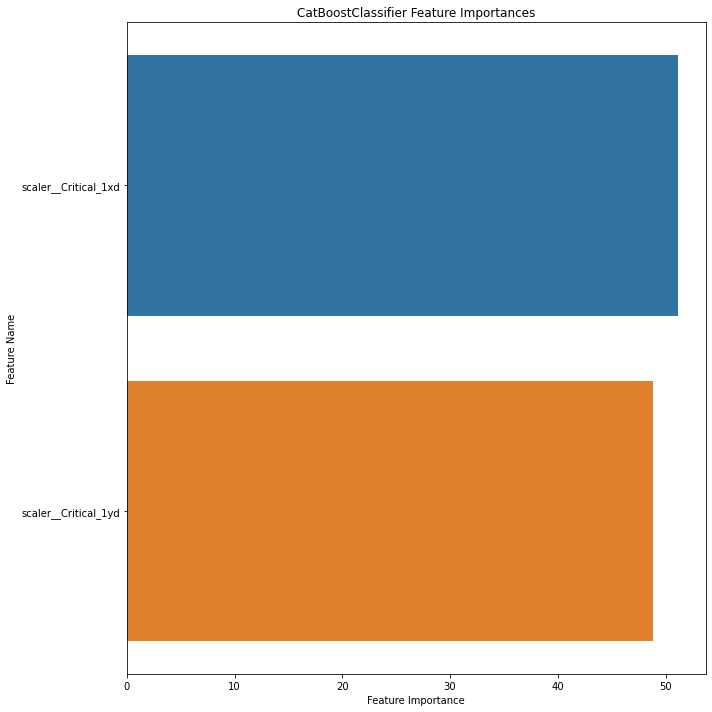

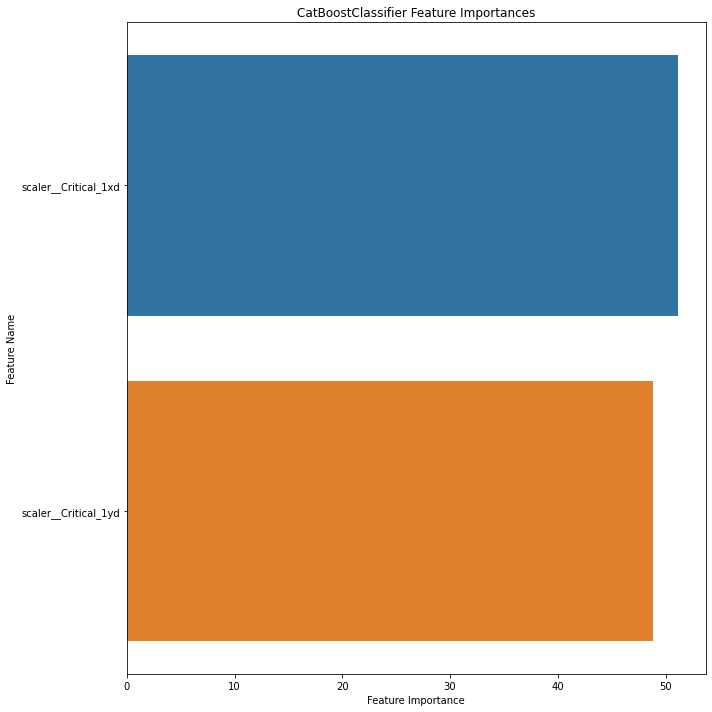

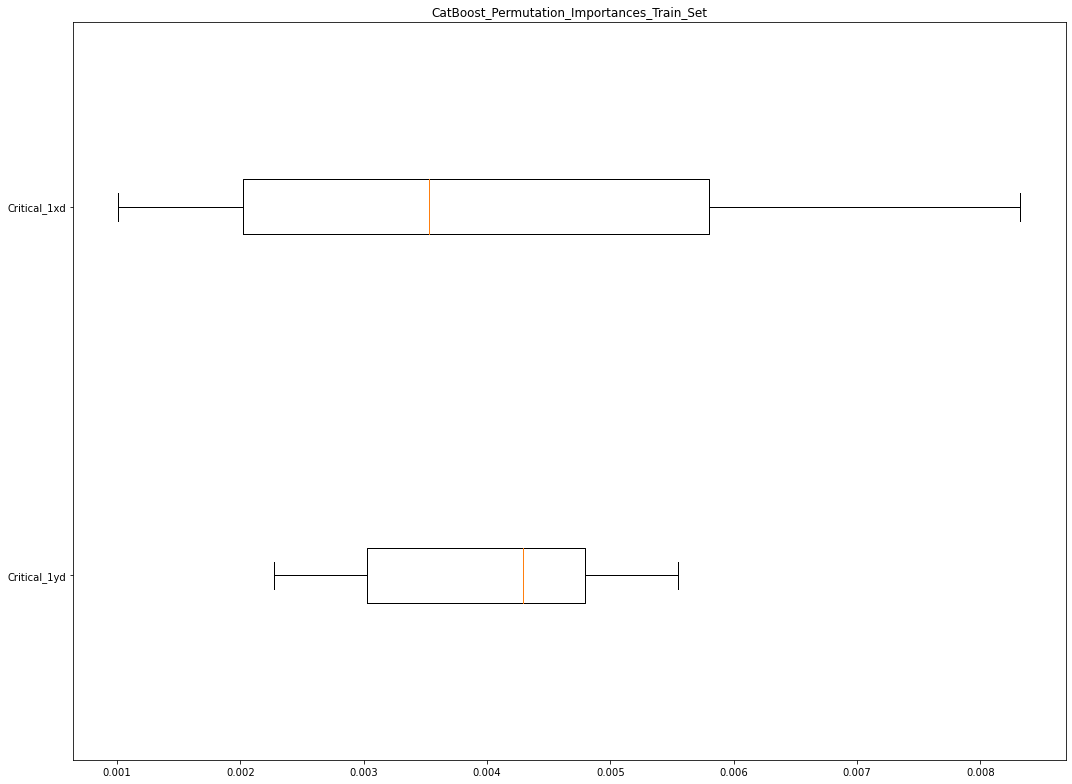

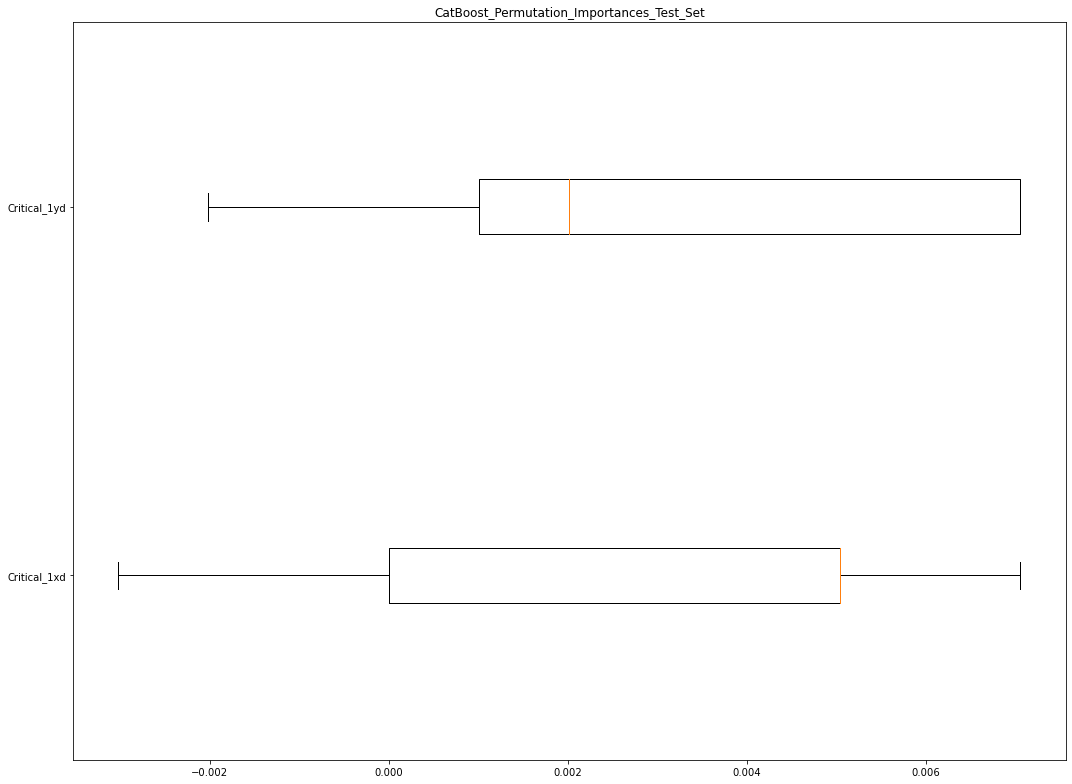

LGBM_bestpipeline_fitted_model


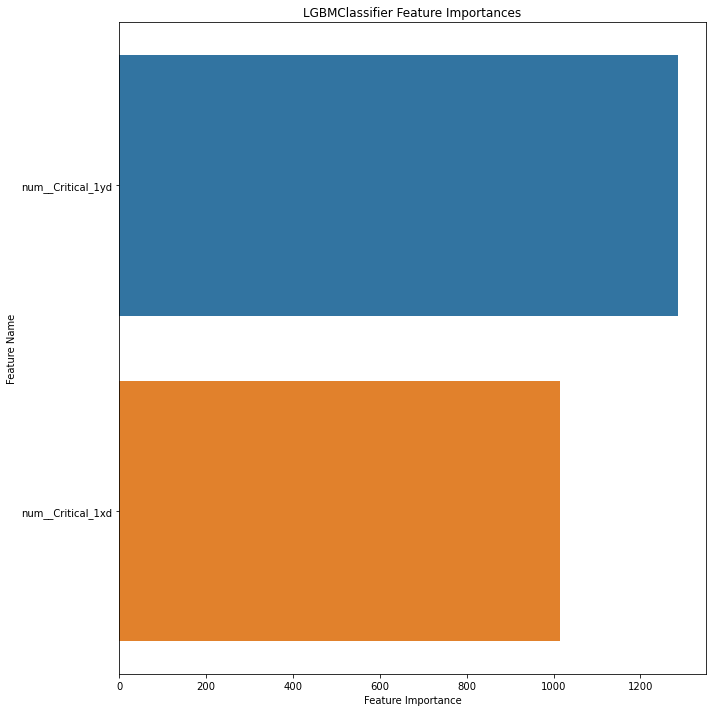

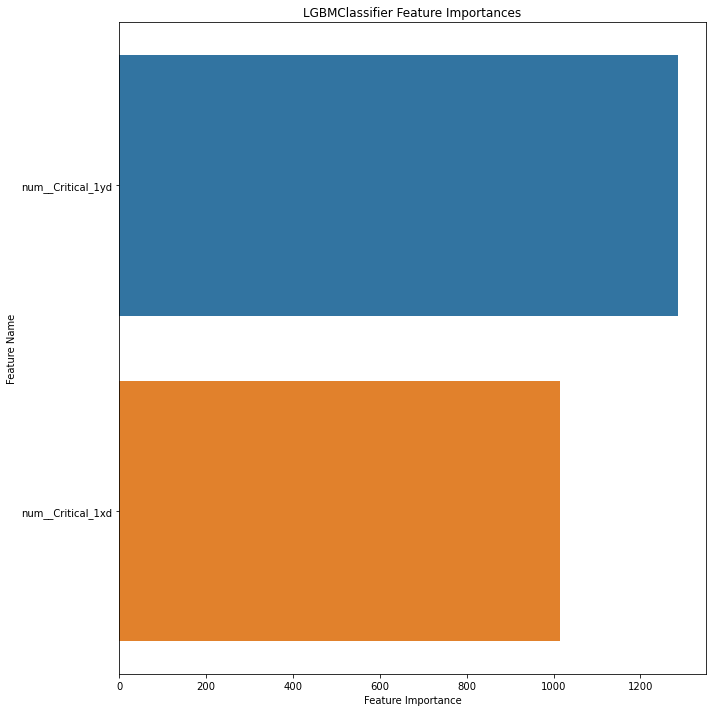

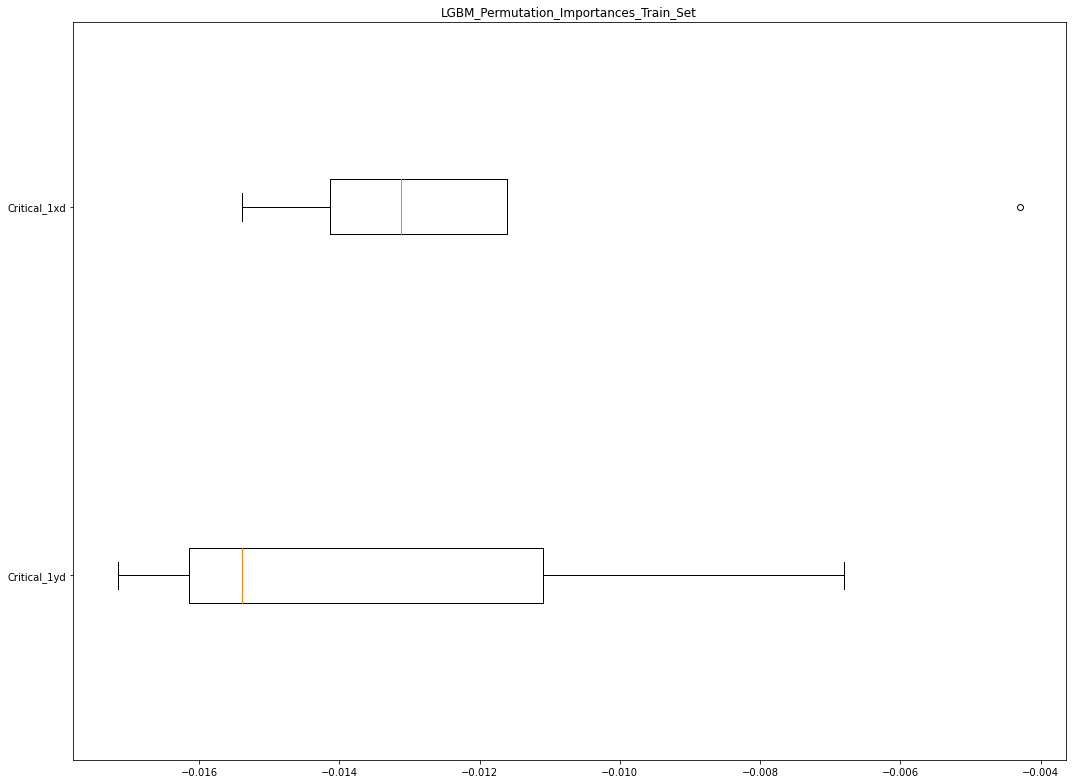

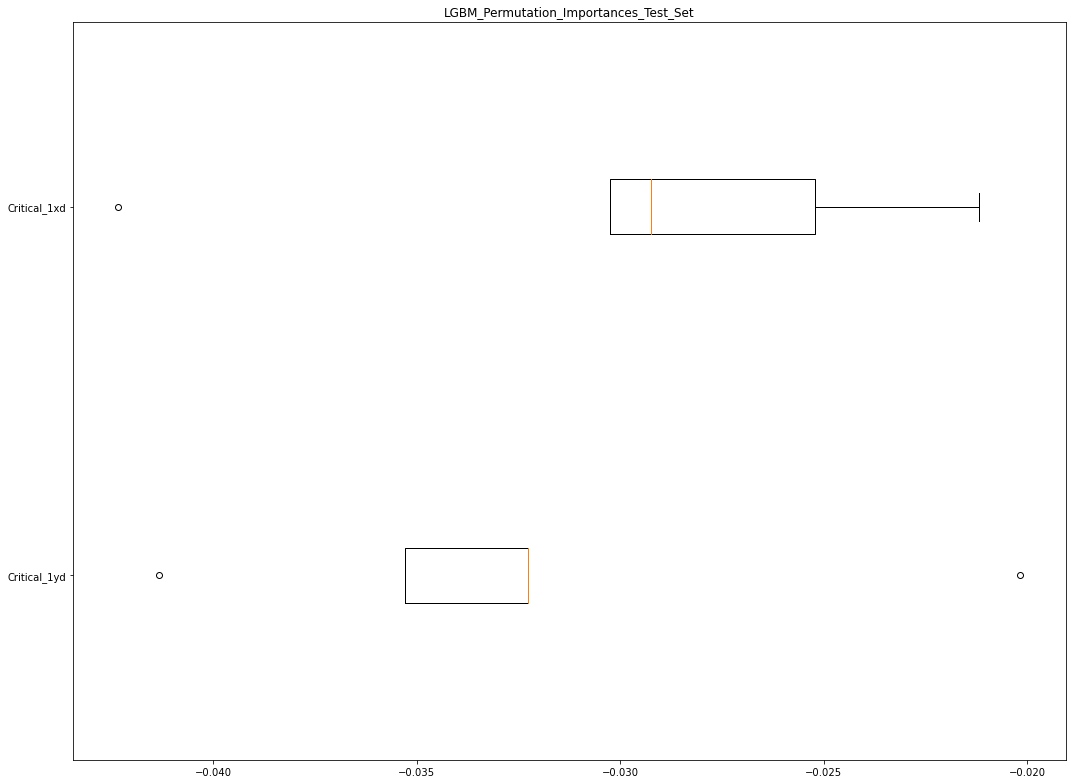

RandomForest_bestpipeline_fitted_model


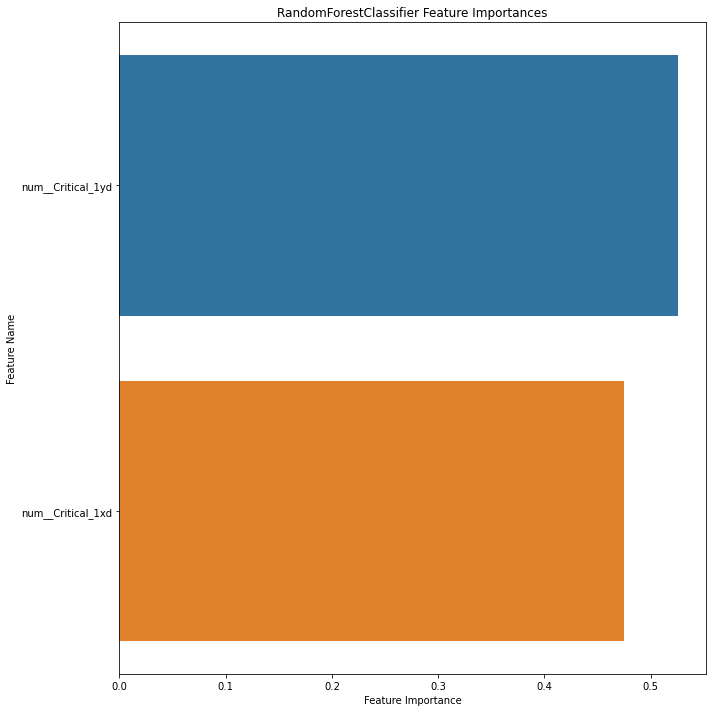

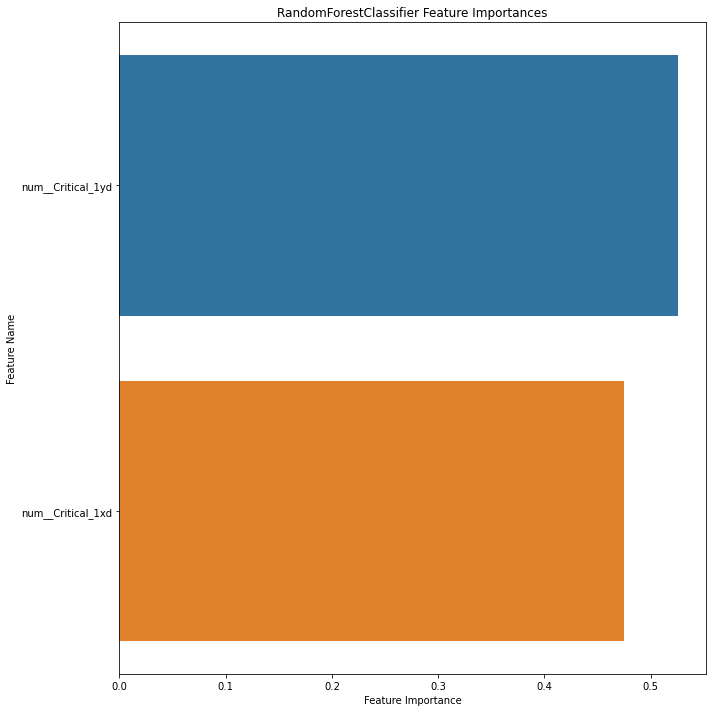

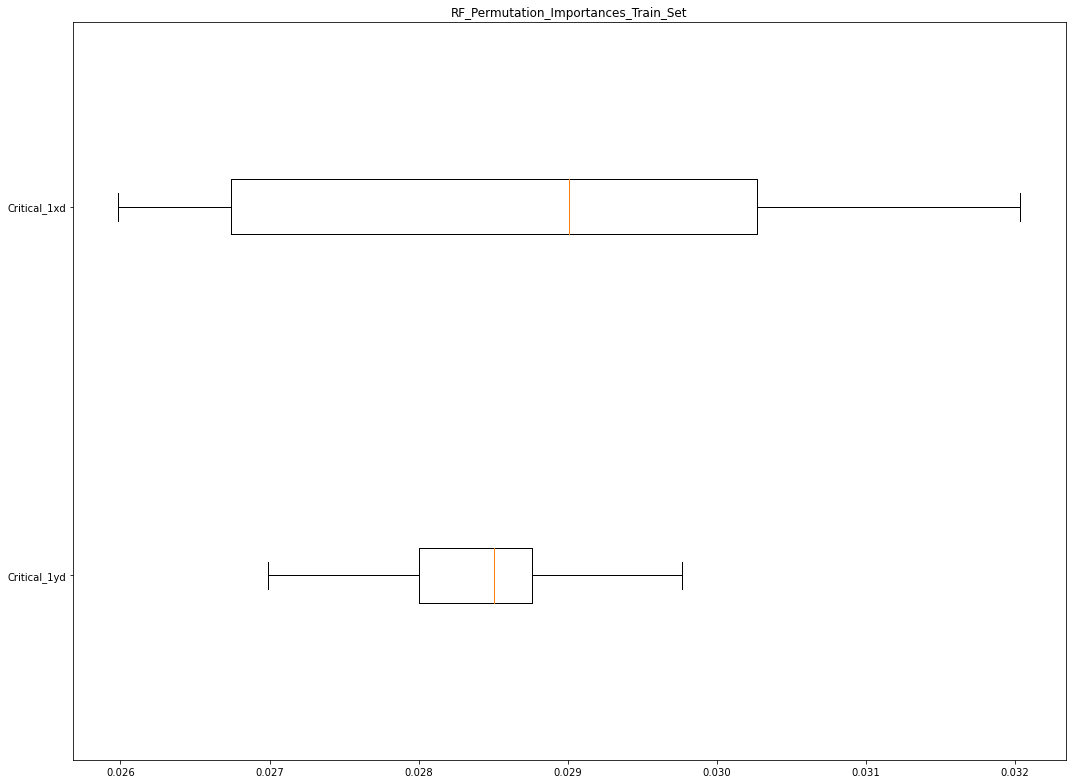

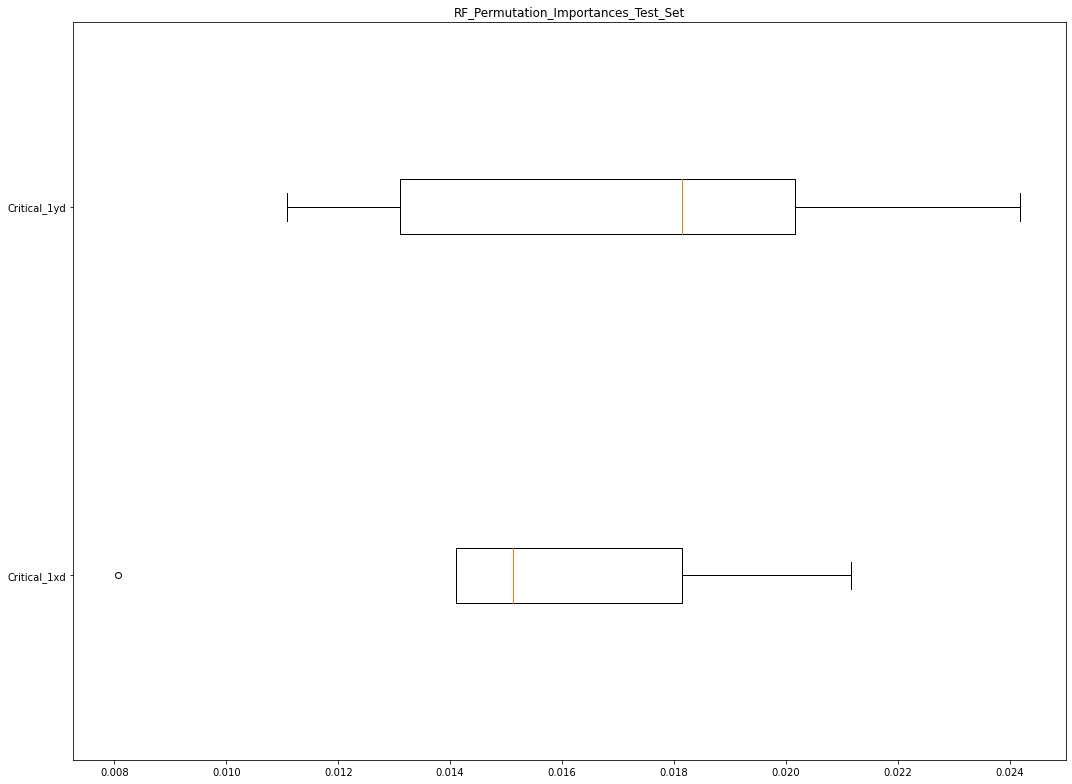

In [80]:
best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")
metrics = {}

for model in best_fitted_models.keys():
    print(model)
    model_path = output_folder + 'models/' + f'{model}.joblib'
    
        
    if model == 'CatBoost_bestpipeline_fitted_model':
        CatBoost_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(CatBoost_bestpipeline_fitted_model,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_Feature_Importances_Combined.png')
        fe.plot_feature_importance(CatBoost_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_Feature_Importances_Individual.png')
                
        fe.plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = CatBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["CatBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        

        
    if model == 'XGBoost_bestpipeline_fitted_model':
        XGBoost_bestpipeline_fitted_model = load(model_path)
        fe.plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Combined.png')
        fe.plot_feature_importance(XGBoost_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances_Individual.png')

        fe.plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = XGBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["XGBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
    if model == 'LGBM_bestpipeline_fitted_model':
        LGBM_bestpipeline_fitted_model = load(model_path)
        
        fe.plot_feature_importance(LGBM_bestpipeline_fitted_model,
                          output_directory=LGBM_predictions_folder, 
                          title= 'LGBM_Feature_Importances_Combined.png')
        fe.plot_feature_importance(LGBM_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=LGBM_predictions_folder, 
                          title= 'LGBM_Feature_Importances_Individual.png') 
        
        fe.plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_train, y_train, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_test, y_test, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = LGBM_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["LGBM"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
              
    if model == 'RandomForest_bestpipeline_fitted_model':
        RandomForest_bestpipeline_fitted_model = load(model_path)
        
        fe.plot_feature_importance(RandomForest_bestpipeline_fitted_model,
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances_Combined.png')
        fe.plot_feature_importance(RandomForest_bestpipeline_fitted_model,
                          combine_cat_class_importances = False,
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances_Individual.png')
        
        fe.plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_train, y_train, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Train_Set')
        fe.plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_test, y_test, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = RandomForest_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["Random Forest"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        

In [85]:
import imblearn
import catboost
import fasttreeshap

def plot_shap_values(model, X_test, **kwargs):
    """
    Create a plot of shap values for a given pre-fitted estimator. SHAP VALUES DO NOT SUPPORT STACKING CLASSIFIERS
    Parameters
    ----------
    model : imblearn.pipeline.Pipeline model or sklearn classifier
    X_test : pandas.DataFrame
        The test portion of a dataset
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    """
    # REFERENCES :
    # https://github.com/slundberg/shap/issues/406
    # PROBLEM #1 : plot shap_values was plotting categorical variables in gray (see ref above)
    # FIXED #1 : PROBLEM #1 has been resolved. 'features' object of shap.summary_plot must be a numpy array, not a dataframe.

    # PROBLEM #2 : Plot shap values of OneHotEncoded columns in terms of original categorical property (Next Update)
        
    if type(model) == imblearn.pipeline.Pipeline:
        # If the user is using a pipeline model, 
        # the shap values are calculated in this if block!

        pre_model = model['pre'] # Pre step of the pipeline
        classifier = model['clf'] # Classifier of the pipeline
        ct = model.named_steps['pre'] # Define the column transform for the given pipeline model          
        
        if type(classifier) == catboost.core.CatBoostClassifier:
            explainer = fasttreeshap.TreeExplainer(classifier, feature_names=X_test.columns.tolist())
            (n, d) = X_test.shape
       
        elif type(classifier) != catboost.core.CatBoostClassifier:
            # When the user uses a non-CatBoost model (Random Forest, LGBM, XGBoost) with some categorical variables, 
            # the "pre" step of the pipeline applies OneHotEncoder for categorical variables. 
            # In other words, the dimension of X_train and X_test change at the "pre" stage of the pipeline. 
            # For this reason, the columns of X_test are not recognized by the bestpipeline_fitted_model, 
            # but the columns of the column-transformed version are. 
            # Therefore, we need to apply a column transform first and then check the shap values of individual OneHotEncoder columns.
            
            # In the next update, the shap values of the OneHotEncoder columns will be collected and written 
            # in terms of the original categorical feature.
                        
            X_test_transform = pd.DataFrame(ct.transform(X_test), columns= pre_model.get_feature_names_out().tolist())    
            explainer = fasttreeshap.TreeExplainer(classifier, feature_names=X_test_transform.columns.tolist())
            (n, d) = X_test_transform.shape    
    
    else:
        explainer = fasttreeshap.TreeExplainer(model, feature_names=X_test.columns.tolist())
        (n, d) = X_test.shape    

    # Plotting part starts here!
    # The plotting part can be written in a cleaner way.
    # However, shap.summary_plot calls 'plt.show()' to ensure the plot displays, which makes it
    # a bit difficult to save two consecutive summary plots.
    # Therefore, we have to set 'show=False' for the first shap.summary_plot.
    # If an output_directory is set, only the second plot will be displayed, but both plots will be saved separately.
    # If an output_directory is NOT set, then both plots will be displayed. However, none of them will be saved.
    
    if "output_directory" in kwargs:
        show=False
        if not os.path.exists(kwargs['output_directory']):
            os.makedirs(kwargs['output_directory'])
    else:
        show=True    
    
    # Let's compute shap values and plot the first summary_plot
    if type(model) == imblearn.pipeline.Pipeline:
        if type(classifier) == catboost.core.CatBoostClassifier:
            shap_vals = explainer.shap_values(X_test)
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, max_display = d, show=show)
        elif type(classifier) != catboost.core.CatBoostClassifier:
            shap_vals = explainer.shap_values(X_test_transform)
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test_transform), feature_names=X_test_transform.columns, max_display = d, show=show)
    else:
        shap_vals = explainer.shap_values(X_test)
        fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, max_display = d, show=show)
    
    # "set_size" is OPTIONAL to change the size of the figures
    if "set_size" in kwargs:
        fig1 = plt.gcf()
        fig1.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
        fig1.tight_layout()
    else:
        fig1 = plt.gcf()
        fig1.set_size_inches(12, 12)
        fig1.tight_layout()

    if "output_directory" in kwargs:
        fig1.savefig(os.path.join(kwargs['output_directory'], 'shap_summary.png'))
        fig1.clf()

    # Let's plot the second summary_plot with a plot_type="bar"   
    if type(model) == imblearn.pipeline.Pipeline:
        if type(classifier) == catboost.core.CatBoostClassifier:
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, plot_type="bar", max_display = d, show=show)
        elif type(classifier) != catboost.core.CatBoostClassifier:
            fasttreeshap.summary_plot(shap_vals, features=np.array(X_test_transform), feature_names=X_test_transform.columns, plot_type="bar", max_display = d, show=show)
    else:
        fasttreeshap.summary_plot(shap_vals, features=np.array(X_test), feature_names=X_test.columns, plot_type="bar", max_display = d, show=show)
    
    # "set_size" is OPTIONAL to change the size of the figures
    if "set_size" in kwargs:
        fig2 = plt.gcf()
        fig2.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
        fig2.tight_layout()
    else:
        fig2 = plt.gcf()
        fig2.set_size_inches(12, 12)
        fig2.tight_layout()    
    
    if "output_directory" in kwargs:
        fig2.savefig(os.path.join(kwargs['output_directory'], 'shap_summary_barplot.png'))
        
    return shap_vals

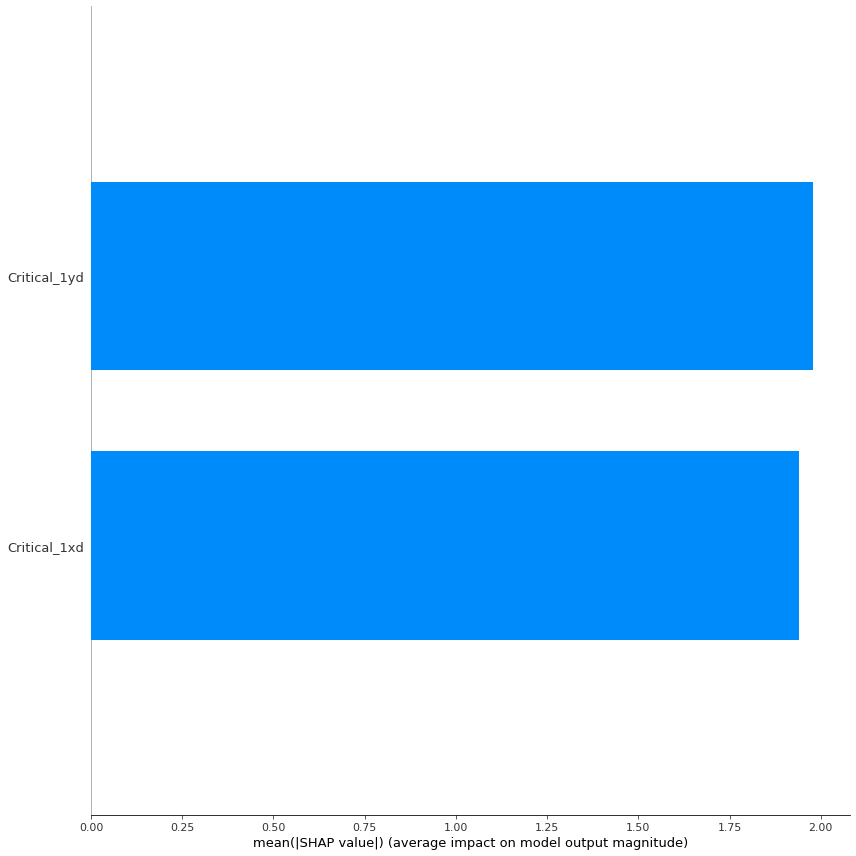

In [87]:
fe.plot_shap_values(CatBoost_bestpipeline_fitted_model,
                 X_test,
                 output_directory=CatBoost_predictions_folder, 
                 title= 'CatBoost_SHAP_values.png')